In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# pip install pgzip==0.3.0

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17880240748975937104
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3680501760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13258244186559419870
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
import numpy as np

import sys
import time
sys.path.append("./Models")
import os
os.system('')

import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

In [5]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "dyt" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
param_dset_lookback_weeks = 5
param_dset_forecast = 48 if arg_dset == "lsm" else 24
# param_dset_lookback_weeks = 9
# param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False



In [6]:
import pywt
from tqdm.auto import tqdm

# Get the maximum decomposition level
def print_maximal_decom_level(data):
    max_level = pywt.swt_max_level(data)
    print("Maximum decomposition level:", max_level)

    return max_level

# SWT functions
def data_preparation(dataset, window, lev):
    da = []
    max_level = print_maximal_decom_level(window)
    for i in tqdm(range(len(dataset)), total=len(dataset), desc="swt"):
        coeffs = pywt.swt(dataset[i], wavelet='db2', level=lev)
        da.append(coeffs);
    return da

def data_reconstruction(dataset):
    da = []
    for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
#         recon = pywt.iswt(dataset[i,:,:,:].tolist(), 'db2')
        recon = pywt.iswt(dataset[i], 'db2')
#         print(np.array(recon).shape)
        da.append(recon)
#         da.append(recon[0][window-1])
    return da


# Called because iswt cannot accept tolist() dataset
def data_organization(coeffs):
    '''
    Reshape data back to (n,3,2,window_length), where there are 3 tuples of 2 values consisting of
    coeffs array_like Coefficients list of tuples:
    [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)]
    '''
    reshape_list = []
    for i in range(len(coeffs)):
        reshape_list.append([])
        for j in range(len(coeffs[0])):
            reshape_list[i].append(tuple(coeffs[i][j]))

    return reshape_list

In [7]:
# -*- coding: utf-8 -*-

import numpy as np

import os
import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

class DAYTON(Dataset):
    """
    PJM-DAYTON dataset. Instantaneous power reported in MW.
    Ranges from around ??? GW (???? MW) to ??? GW (???? MW).
    """
    def __init__(self,path = '.',start_idx = 0, end_idx = 9999999,
                 seq_len = 816, pred_horz = 24, stride=-1, timestamp = True):
        assert(end_idx - start_idx > seq_len+pred_horz)
        if stride <= 0:
            stride = seq_len+pred_horz
        #if 'aep_tensor.pkl' not in os.listdir(path) or 'aep_timestamps.pkl' not in os.listdir(path):
        if 'dayton_dict.pkl.pgz' not in os.listdir(path):
            raise FileNotFoundError(os.listdir(path))
            #subprocess.check_call('python ./dayton_.py . aep_dict.pkl.pgz')

        # with open(os.path.join(path,'aep_tensor.pkl'),'rb') as f:
        #     series = pickle.load(f)
        # with open(os.path.join(path,'aep_timestamps.pkl'),'rb') as f:
        #     timestamps = pickle.load(f)

        with pgzip.open(os.path.join(path,'dayton_dict.pkl.pgz')) as f:
            sd = pickle.load(f)

        series = sd["tensor"] #121296 total elements
        starttime = sd['start_time']

        self.total_datapoints = len(series)

        end_idx = min(end_idx,len(series))

        wset = []
        ser_start = []
        pred_start = []
        i = start_idx
        while i + seq_len + pred_horz < end_idx:
            wset.append(series[i:i+seq_len+pred_horz])
            # ser_start.append(timestamps[i])
            # pred_start.append(timestamps[i+seq_len+1])
            ser_start.append(starttime + i*datetime.timedelta(hours=1))
            pred_start.append(starttime + (i + seq_len)*datetime.timedelta(hours=1))
            i += stride

        wset = torch.stack(wset).unsqueeze(-1)
        self.series = wset

        for i in range(len(ser_start)):
            tmptime = ser_start[i]
            ser_start[i] = [tmptime.year,
                            tmptime.month,
                            tmptime.day,
                            tmptime.hour,
                            tmptime.minute,
                            tmptime.second]

        for i in range(len(pred_start)):
            tmptime = pred_start[i]
            pred_start[i] = [tmptime.year,
                            tmptime.month,
                            tmptime.day,
                            tmptime.hour,
                            tmptime.minute,
                            tmptime.second]

        #Series normalization
        #Convert nans so that they do not count toward the min/max
        # smin = self.series.nan_to_num(nan=torch.finfo(self.series.dtype).max).amin(dim=-2,keepdim=True)
        # smax = self.series.nan_to_num(nan=torch.finfo(self.series.dtype).min).amax(dim=-2,keepdim=True)

        self._min = self.series[~self.series.isnan()].min()
        self._max = self.series[~self.series.isnan()].max()

        #self.series = (self.series - smin.broadcast_to(self.series.shape))/(smax-smin).broadcast_to(self.series.shape)
        self.series_starttimes = torch.tensor(ser_start,dtype=torch.long)
        self.pred_start = torch.tensor(pred_start,dtype=torch.long)

        self.length = len(self.series)
        self.return_timestamps = timestamp

        self.seq_len = seq_len
        self.pred_horz = pred_horz

        #Dataset in use will contain nans, to be handled by the training code

    def __len__(self):
        return self.length

    def min(self):
        """Returns the minimum load power in GW"""
        return self._min
        #return 18.041

    def max(self):
        """Returns the maximum load power in GW"""
        return self._max
        #return 41.015

    def __getitem__(self,idx):
        if self.return_timestamps:
            return self.series[idx][:self.seq_len], self.series[idx][self.seq_len:], self.series_starttimes[idx], self.pred_start[idx]
        return self.series[idx][:self.seq_len], self.series[idx][self.seq_len:]

In [8]:
# path = '/content/gdrive/MyDrive/FYP/Datasets/PJM_energy_datasets'
path = '.'
import sys
sys.path.insert(0,path)

full_set = DAYTON(path = ".",
                  seq_len = param_dset_lookback,
                  pred_horz = param_dset_forecast,
                  timestamp = False)
dytmax = full_set.max()
dytmin = full_set.min()
del(full_set)

train_set = DAYTON(path = ".",
                start_idx = 0, end_idx = 97036,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=29,
                timestamp = False)
val_set = DAYTON(path = ".",
              start_idx = 97036, end_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)
test_set = DAYTON(path = ".",
                start_idx = 97036+12129,
                seq_len = param_dset_lookback,
                pred_horz = param_dset_forecast,
                stride=param_dset_forecast,
                timestamp = False)


train_set.series = (train_set.series - dytmin)/(dytmax - dytmin)
val_set.series = (val_set.series - dytmin)/(dytmax - dytmin)
test_set.series = (test_set.series - dytmin)/(dytmax - dytmin)

print(train_set.series.shape)

torch.Size([3318, 840, 1])


In [9]:
#SWT Transformation
def swt_transformation(self_series):
    self_series = self_series.squeeze(-1)
    print("total series shape after squeeze: ", self_series.shape)
    self_series_numpy = self_series.numpy()
    print("torch shape: ", self_series.shape)
    print("numpy shape: ", self_series_numpy.shape)
#     print(self_series[0])
#     print(self_series_numpy[0])
    lev = 3
    da = data_preparation(self_series_numpy, self_series_numpy.shape[1], lev)
#     print(da[0][0])

    Vv = np.array(da)
    print(Vv.shape)
    # print(Vv[0][0])

    vv = Vv.reshape(Vv.shape[0],2*lev*Vv.shape[3])
    print(vv.shape)


    # dataset = scaler.fit_transform(vv)

    dat = vv.reshape(Vv.shape[0],2*lev,Vv.shape[3])
    print(dat.shape)

    # Check Reconstruction whether it is correct -> This is correct
    # D = dat.reshape(Vv.shape[0],2*lev*Vv.shape[3])
    # print(D.shape)
    
    # R = D.reshape(Vv.shape[0],lev,2,Vv.shape[3])
    # print(R.shape)
    
    # R = data_organization(R)
    # # print(R[0][0])

    # re=data_reconstruction(R)
    # Re = np.array(re)
    # print(Re.shape)
    # print(self_series[0])
    # print(Re[0])

    return dat

train_set_transform = swt_transformation(train_set.series[:,:param_dset_lookback])
print("train_set_transform shape: ", train_set_transform.shape)
print("----------------------------------------------------")

val_set_transform = swt_transformation(val_set.series[:,:param_dset_lookback])
print("val_set_transform shape: ", val_set_transform.shape)
print("----------------------------------------------------")

test_set_transform = swt_transformation(test_set.series[:,:param_dset_lookback])
print("test_set_transform shape: ", test_set_transform.shape)
print("----------------------------------------------------")

total series shape after squeeze:  torch.Size([3318, 816])
torch shape:  torch.Size([3318, 816])
numpy shape:  (3318, 816)
Maximum decomposition level: 4


swt:   0%|          | 0/3318 [00:00<?, ?it/s]

(3318, 3, 2, 816)
(3318, 4896)
(3318, 6, 816)
train_set_transform shape:  (3318, 6, 816)
----------------------------------------------------
total series shape after squeeze:  torch.Size([471, 816])
torch shape:  torch.Size([471, 816])
numpy shape:  (471, 816)
Maximum decomposition level: 4


swt:   0%|          | 0/471 [00:00<?, ?it/s]

(471, 3, 2, 816)
(471, 4896)
(471, 6, 816)
val_set_transform shape:  (471, 6, 816)
----------------------------------------------------
total series shape after squeeze:  torch.Size([471, 816])
torch shape:  torch.Size([471, 816])
numpy shape:  (471, 816)
Maximum decomposition level: 4


swt:   0%|          | 0/471 [00:00<?, ?it/s]

(471, 3, 2, 816)
(471, 4896)
(471, 6, 816)
test_set_transform shape:  (471, 6, 816)
----------------------------------------------------


In [10]:
# Concat swt as features with original data as inputs
swt_train_features=torch.from_numpy(np.transpose(train_set_transform, (0, 2, 1)))
swt_val_features =torch.from_numpy(np.transpose(val_set_transform, (0, 2, 1)))
swt_test_features=torch.from_numpy(np.transpose(test_set_transform, (0, 2, 1)))

print(swt_train_features.shape)
print(swt_val_features.shape)
print(swt_test_features.shape)


torch.Size([3318, 816, 6])
torch.Size([471, 816, 6])
torch.Size([471, 816, 6])


In [11]:
# Split seq_len and pred

trainX,trainY = train_set.series[:int(train_set_transform.shape[0]),:param_dset_lookback,:], train_set.series[:int(train_set_transform.shape[0]),param_dset_lookback:,:]
valX,valY = val_set.series[:,:param_dset_lookback,:], val_set.series[:,param_dset_lookback:,:]
testX,testY = test_set.series[:,:param_dset_lookback,:], test_set.series[:,param_dset_lookback:,:]

print(trainX.shape)
print(valX.shape)
print(testX.shape)

print(trainY.shape)
print(valY.shape)
print(testY.shape)

trainX = torch.cat((trainX, swt_train_features), dim=-1)
valX = torch.cat((valX, swt_val_features), dim=-1)
testX = torch.cat((testX, swt_test_features), dim=-1)

print(trainX.shape)
print(valX.shape)
print(testX.shape)





torch.Size([3318, 816, 1])
torch.Size([471, 816, 1])
torch.Size([471, 816, 1])
torch.Size([3318, 24, 1])
torch.Size([471, 24, 1])
torch.Size([471, 24, 1])
torch.Size([3318, 816, 7])
torch.Size([471, 816, 7])
torch.Size([471, 816, 7])


## Model Initialization

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# path1 = "/content/gdrive/MyDrive/FYP/Models"
# path2 = "/content/gdrive/MyDrive/FYP/Models/BigBirdSparse"
# import sys
# sys.path.insert(1,path1)
# sys.path.insert(2,path2)
import sys
sys.path.append("../../Models")

from Encodings.encoding import LearnablePositionalEncoding
from BigBirdSparse.bb_sparse import BlockSparseMultiheadAttention
from BigBirdSparse.bb_fixed import BlockSparseFixedAttention
from transformer_base import TBatchNorm

class TransformerBBSparse(nn.Module):
    def __init__(self, seq_len=2560, out_seq_len=24, interval=1, inp_dim=1, emb_dim=64,\
                 n_heads=4, n_enc_layers=2, n_dec_layers=2, block_size=40,\
                ffdim=128, drop_p = 0.1):
        super(TransformerBBSparse,self).__init__()
        self.seq_len = seq_len
        self.out_seq_len = out_seq_len
        self.emb_dim = emb_dim
        #self.in_norm = nn.BatchNorm1d(seq_len,affine=False)
        self.input_linear = nn.Linear(inp_dim,emb_dim)
        #self.input_pool = nn.AvgPool1d(kernel_size=5,stride=5)
        self.pe = LearnablePositionalEncoding(emb_dim,dropout=0.1,max_len=seq_len)
        #self.pe = CosineEmbedding(emb_dim,max_len=seq_len,scale_factor=0.1)
        #self.tpe = TimestampCosineEmbedding(emb_dim, interval, max_len = seq_len)

        self.trf_el = nn.TransformerEncoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)
        self.trf_el.self_attn = BlockSparseMultiheadAttention(emb_dim, n_heads, block_size,batch_first=True)
        #self.trf_el.self_attn = BlockSparseMheadAttnFixed(emb_dim, n_heads, block_size,batch_first=True)

        self.trf_dl = nn.TransformerDecoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)

        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm2 = TBatchNorm(num_features=emb_dim)

        self.trf_dl.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm2 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm3 = TBatchNorm(num_features=emb_dim)

        self.trf_e = nn.TransformerEncoder(self.trf_el,num_layers=n_enc_layers)
        self.trf_d = nn.TransformerDecoder(self.trf_dl,num_layers=n_dec_layers)

        # self.out = nn.Linear(emb_dim,inp_dim)
        self.out = nn.Linear(emb_dim,1)
        self.drop = nn.Dropout(p=drop_p)

        # self.dec_tar = torch.nn.Parameter(torch.zeros((out_seq_len,emb_dim)))
        # nn.init.normal_(self.dec_tar)
        self.aux_out = nn.Linear(emb_dim,1)#inp_dim)
        #self.reduce = nn.Linear(seq_len,out_seq_len)
        self.aux_in = nn.Linear(1,emb_dim)#inp_dim,emb_dim)

        self.expand = nn.Linear(seq_len,5120)
        self.compress = nn.Linear(5120,out_seq_len)

    def forward(self,x):
        '''x: [batch dim, sequence length, variable dim]'''
        x1 = self.input_linear(x) # x1.shape: [batch, seq len, emb dim]
        x1 = self.pe(x1.permute(1,0,2)).permute(1,0,2)
        #x1 = self.tpe(x1.permute(1,0,2),in_start_time).permute(1,0,2)
        mem = self.trf_e(x1)

        dec_in = self.aux_out(mem)
        dec_in = F.gelu(self.expand(dec_in.view((-1,self.seq_len))))
        dec_in = self.drop(dec_in)
        dec_in = self.compress(dec_in)
        #dec_in = F.gelu(self.reduce(dec_in.view((-1,self.seq_len))))

        dec_in = self.aux_in(dec_in.unsqueeze(-1))

        # x2 = self.trf_d(self.dec_tar.broadcast_to(x.shape[0],self.out_seq_len,self.emb_dim)\
        #                 ,mem)
        x2 = self.trf_d(self.pe(dec_in.permute(1,0,2))\
                        .permute(1,0,2),mem)
        # x2 = self.trf_d(self.tpe(dec_in.permute(1,0,2),pred_start_time)\
        #                 .permute(1,0,2),mem)

        o1 = self.out(x2)

        return o1



In [13]:
class TransformerBBFixed(nn.Module):
    def __init__(self, seq_len=2560, out_seq_len=24, interval=1, inp_dim=1, emb_dim=64,\
                 n_heads=4, n_enc_layers=2, n_dec_layers=2, block_size=40,\
                ffdim=128, drop_p = 0.1):
        super(TransformerBBFixed,self).__init__()
        self.seq_len = seq_len
        self.out_seq_len = out_seq_len
        self.emb_dim = emb_dim
        #self.in_norm = nn.BatchNorm1d(seq_len,affine=False)
        self.input_linear = nn.Linear(inp_dim,emb_dim)
        #self.input_pool = nn.AvgPool1d(kernel_size=5,stride=5)
        self.pe = LearnablePositionalEncoding(emb_dim,dropout=drop_p,max_len=seq_len)
        #self.pe = CosineEmbedding(emb_dim,max_len=seq_len,scale_factor=0.1)
        #self.tpe = TimestampCosineEmbedding(emb_dim, interval, max_len = seq_len)

        self.trf_el = nn.TransformerEncoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)
        #self.trf_el.self_attn = BlockSparseMultiheadAttention(emb_dim, n_heads, block_size,batch_first=True)
        self.trf_el.self_attn = BlockSparseFixedAttention(emb_dim, n_heads, block_size,batch_first=True)

        self.trf_dl = nn.TransformerDecoderLayer(emb_dim,n_heads,ffdim,
                                                 activation=F.gelu,dropout=drop_p,
                                                 batch_first=True,norm_first=True)

        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_el.norm2 = TBatchNorm(num_features=emb_dim)

        self.trf_dl.norm1 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm2 = TBatchNorm(num_features=emb_dim)
        self.trf_dl.norm3 = TBatchNorm(num_features=emb_dim)

        self.trf_e = nn.TransformerEncoder(self.trf_el,num_layers=n_enc_layers)
        self.trf_d = nn.TransformerDecoder(self.trf_dl,num_layers=n_dec_layers)

        # self.out = nn.Linear(emb_dim,inp_dim)
        self.out = nn.Linear(emb_dim,1)
        self.drop = nn.Dropout(p=drop_p)

        # self.dec_tar = torch.nn.Parameter(torch.zeros((out_seq_len,emb_dim)))
        # nn.init.normal_(self.dec_tar)
        self.aux_out = nn.Linear(emb_dim,1)#inp_dim)
        #self.reduce = nn.Linear(seq_len,out_seq_len)
        self.aux_in = nn.Linear(1,emb_dim)#inp_dim,emb_dim)

        self.expand = nn.Linear(seq_len,5120)
        self.compress = nn.Linear(5120,out_seq_len)

    def forward(self,x):
        '''x: [batch dim, sequence length, variable dim]'''
        x1 = self.input_linear(x) # x1.shape: [batch, seq len, emb dim]
        x1 = self.pe(x1.permute(1,0,2)).permute(1,0,2)
        #x1 = self.tpe(x1.permute(1,0,2),in_start_time).permute(1,0,2)
        mem = self.trf_e(x1)

        dec_in = self.aux_out(mem)
        dec_in = F.gelu(self.expand(dec_in.view((-1,self.seq_len))))
        dec_in = self.drop(dec_in)
        dec_in = self.compress(dec_in)
        #dec_in = F.gelu(self.reduce(dec_in.view((-1,self.seq_len))))

        dec_in = self.aux_in(dec_in.unsqueeze(-1))

        # x2 = self.trf_d(self.dec_tar.broadcast_to(x.shape[0],self.out_seq_len,self.emb_dim)\
        #                 ,mem)
        x2 = self.trf_d(self.pe(dec_in.permute(1,0,2))\
                        .permute(1,0,2),mem)
        # x2 = self.trf_d(self.tpe(dec_in.permute(1,0,2),pred_start_time)\
        #                 .permute(1,0,2),mem)

        o1 = self.out(x2)

        return o1

In [14]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class SaveBestModel:
    """
    Class to save or load the best model while training.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss, epoch, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
#             print(f"\nBest validation loss: {self.best_valid_loss}")
#             print(f"\nSaving best model for epoch: {epoch+1}\n")
            # Save the PyTorch model
            torch.save(model.state_dict(), 'transformer_5min.pth')

patience = 50
early_stopper = EarlyStopper(patience=patience, min_delta=0)
saveBestModel = SaveBestModel()

## Create model and data tensor

In [17]:
batch_size = 64
lev=3

seq_len = param_dset_lookback

# Transformer parameters
inp_len = 2* lev + 1
out_len = 2*lev
emb_dim = 24
n_heads = 4
enc_layer = 4
dec_layer = 4
ff_dim = 256
param_trf_bksz = 48

In [18]:
# model = create_model()
# model.summary()

# # Training data
# X_train, y_train = trainX,trainY
# ###############################################################################
# # Validation data
# X_val, y_val = testX,testY
# ###############################################################################
# # Test data
# X_test, y_test = testX_a,testY_a
# callback = tf.keras.callbacks.ModelCheckpoint('Transformer_5min.hdf5',
#                                                       monitor='val_loss',
#                                                       save_best_only=True,
#                                                       verbose=1)
# with tf.device("/gpu:0"):
#     history = model.fit(X_train, y_train,
#                             batch_size=batch_size,
# #                             epochs=50,
#                             epochs=1,
#                             validation_data=(X_val, y_val),
#                             callbacks=[callback])

# model = tf.keras.models.load_model('Transformer_5min.hdf5',
#                                            custom_objects={'Time2Vector': Time2Vector,
#                                                            'SingleAttention': SingleAttention,
#                                                            'MultiAttention': MultiAttention,
#                                                            'TransformerEncoder': TransformerEncoder,
#                                                            'TransformerDecoder': TransformerDecoder}
#                                            )

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)

# Create PyTorch model
model = TransformerBBSparse(seq_len = param_dset_lookback,
                          # out_seq_len = param_dset_forecast,
                          out_seq_len = param_dset_forecast,
                          inp_dim = inp_len,
                          emb_dim = emb_dim,
                          n_heads = n_heads,
                          n_enc_layers = enc_layer,
                          n_dec_layers = dec_layer,
                          block_size=param_trf_bksz,
                          ffdim = ff_dim)

# Print model summary
# print(model)
def num_parameters(m):
    return sum([p.numel() for p in m.parameters()])

parameters = num_parameters(model)

# print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of model parameters: {parameters}")

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {trainable_params}" )

# total_params = 0
# for name, parameter in model.named_parameters():
#     if not parameter.requires_grad:
#         continue
#     params = parameter.numel()
#     print(f"{name}, {params}")
#     total_params+=params
# print(f"Total Trainable Params: {total_params}")


# Convert data to PyTorch tensors
X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
X_val, y_val = torch.tensor(valX), torch.tensor(valY)
X_test, y_test = torch.tensor(testX), torch.tensor(testY)

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

# Training loop
num_epochs = 1000  # Replace with your desired number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

for epoch in tqdm(range(num_epochs), total= num_epochs, desc="epochs", position=0, leave=True):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader, total=len(train_loader), desc="train batches", position=1, leave=True):
        inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # print("inputs: ", inputs.shape)
        # print("targets: ", targets.shape)
        # print("outputs: ", outputs.shape)
        loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])

#         loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

#         for p in model.parameters():
#             print(p.grad.norm())

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, total=len(val_loader), desc="val batches", position=2, leave=True):
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

    saveBestModel(val_loss, epoch, model)

    # Early stopping with patience
    if early_stopper.early_stop(val_loss):
        print("Done!")
        break


Actual number of model parameters: 4488698
Trainable model parameters: 4488698
cuda


C:\Users\linwa\AppData\Local\Temp\ipykernel_14624\1274684628.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
C:\Users\linwa\AppData\Local\Temp\ipykernel_14624\1274684628.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, y_val = torch.tensor(valX), torch.tensor(valY)
C:\Users\linwa\AppData\Local\Temp\ipykernel_14624\1274684628.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(testX), torch.tensor(testY)


epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/1000, Training Loss: 42.572901, Validation Loss: 0.080680


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/1000, Training Loss: 0.055541, Validation Loss: 0.202384


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/1000, Training Loss: 0.043582, Validation Loss: 0.174582


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/1000, Training Loss: 0.037220, Validation Loss: 0.102158


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/1000, Training Loss: 0.032225, Validation Loss: 0.083173


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/1000, Training Loss: 0.030035, Validation Loss: 0.080525


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/1000, Training Loss: 0.029021, Validation Loss: 0.052514


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/1000, Training Loss: 0.034027, Validation Loss: 0.058941


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/1000, Training Loss: 0.026958, Validation Loss: 0.052273


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/1000, Training Loss: 0.030091, Validation Loss: 0.031859


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/1000, Training Loss: 0.031508, Validation Loss: 0.050811


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/1000, Training Loss: 0.046752, Validation Loss: 0.031391


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/1000, Training Loss: 0.033764, Validation Loss: 0.044446


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/1000, Training Loss: 0.038555, Validation Loss: 0.042698


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/1000, Training Loss: 0.023948, Validation Loss: 0.054622


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/1000, Training Loss: 0.039256, Validation Loss: 0.033394


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/1000, Training Loss: 0.021643, Validation Loss: 0.050126


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/1000, Training Loss: 0.028458, Validation Loss: 0.021336


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/1000, Training Loss: 0.023713, Validation Loss: 0.030235


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/1000, Training Loss: 0.020920, Validation Loss: 0.016974


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21/1000, Training Loss: 0.016685, Validation Loss: 0.025730


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/1000, Training Loss: 0.014267, Validation Loss: 0.026196


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/1000, Training Loss: 0.013414, Validation Loss: 0.015427


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24/1000, Training Loss: 0.009622, Validation Loss: 0.017891


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25/1000, Training Loss: 0.010129, Validation Loss: 0.019947


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26/1000, Training Loss: 4.268997, Validation Loss: 0.030669


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27/1000, Training Loss: 0.031693, Validation Loss: 0.028249


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28/1000, Training Loss: 0.023753, Validation Loss: 0.017679


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29/1000, Training Loss: 0.021355, Validation Loss: 0.018442


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30/1000, Training Loss: 0.019948, Validation Loss: 0.020689


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31/1000, Training Loss: 0.018506, Validation Loss: 0.024783


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32/1000, Training Loss: 0.016593, Validation Loss: 0.040174


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33/1000, Training Loss: 0.014762, Validation Loss: 0.057253


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34/1000, Training Loss: 0.012410, Validation Loss: 0.062840


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35/1000, Training Loss: 0.011433, Validation Loss: 0.065883


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36/1000, Training Loss: 0.012752, Validation Loss: 0.058715


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37/1000, Training Loss: 0.010008, Validation Loss: 0.070500


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38/1000, Training Loss: 0.009456, Validation Loss: 0.108868


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39/1000, Training Loss: 0.013938, Validation Loss: 0.051856


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40/1000, Training Loss: 0.009993, Validation Loss: 0.040601


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41/1000, Training Loss: 0.008272, Validation Loss: 0.037076


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42/1000, Training Loss: 0.008750, Validation Loss: 0.066003


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43/1000, Training Loss: 0.008469, Validation Loss: 0.018204


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44/1000, Training Loss: 0.009011, Validation Loss: 0.054380


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45/1000, Training Loss: 0.008671, Validation Loss: 0.037720


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46/1000, Training Loss: 0.007504, Validation Loss: 0.050896


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47/1000, Training Loss: 0.486545, Validation Loss: 0.024032


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48/1000, Training Loss: 0.021322, Validation Loss: 0.017088


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49/1000, Training Loss: 0.015916, Validation Loss: 0.018370


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50/1000, Training Loss: 0.009499, Validation Loss: 0.020016


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 51/1000, Training Loss: 0.008118, Validation Loss: 0.019218


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 52/1000, Training Loss: 0.007593, Validation Loss: 0.018183


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 53/1000, Training Loss: 0.007821, Validation Loss: 0.020361


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 54/1000, Training Loss: 0.006797, Validation Loss: 0.023614


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 55/1000, Training Loss: 0.006885, Validation Loss: 0.019444


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 56/1000, Training Loss: 0.008145, Validation Loss: 0.018282


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 57/1000, Training Loss: 0.006016, Validation Loss: 0.012363


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 58/1000, Training Loss: 0.006544, Validation Loss: 0.012618


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 59/1000, Training Loss: 0.005885, Validation Loss: 0.011642


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 60/1000, Training Loss: 0.505310, Validation Loss: 0.161274


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 61/1000, Training Loss: 0.017686, Validation Loss: 0.041563


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 62/1000, Training Loss: 0.011412, Validation Loss: 0.028206


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 63/1000, Training Loss: 0.008456, Validation Loss: 0.029022


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 64/1000, Training Loss: 0.006410, Validation Loss: 0.032388


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 65/1000, Training Loss: 0.006313, Validation Loss: 0.048770


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 66/1000, Training Loss: 0.005539, Validation Loss: 0.045462


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 67/1000, Training Loss: 0.005311, Validation Loss: 0.048703


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 68/1000, Training Loss: 0.004885, Validation Loss: 0.055452


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 69/1000, Training Loss: 0.005665, Validation Loss: 0.045344


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 70/1000, Training Loss: 0.004840, Validation Loss: 0.042530


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 71/1000, Training Loss: 0.005662, Validation Loss: 0.030971


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 72/1000, Training Loss: 0.004936, Validation Loss: 0.034233


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 73/1000, Training Loss: 0.005683, Validation Loss: 0.023468


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 74/1000, Training Loss: 0.004527, Validation Loss: 0.015983


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 75/1000, Training Loss: 0.291066, Validation Loss: 0.018184


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 76/1000, Training Loss: 0.019287, Validation Loss: 0.018286


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 77/1000, Training Loss: 0.019318, Validation Loss: 0.018214


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 78/1000, Training Loss: 0.019129, Validation Loss: 0.018317


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 79/1000, Training Loss: 0.019124, Validation Loss: 0.018255


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 80/1000, Training Loss: 0.018781, Validation Loss: 0.018353


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 81/1000, Training Loss: 0.018492, Validation Loss: 0.018583


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 82/1000, Training Loss: 0.018167, Validation Loss: 0.017884


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 83/1000, Training Loss: 0.009006, Validation Loss: 0.011568


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 84/1000, Training Loss: 0.005643, Validation Loss: 0.009528


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 85/1000, Training Loss: 0.005401, Validation Loss: 0.011345


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 86/1000, Training Loss: 0.004995, Validation Loss: 0.015109


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 87/1000, Training Loss: 0.005022, Validation Loss: 0.016849


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 88/1000, Training Loss: 0.004850, Validation Loss: 0.017545


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 89/1000, Training Loss: 0.005766, Validation Loss: 0.015670


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 90/1000, Training Loss: 0.005420, Validation Loss: 0.026105


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 91/1000, Training Loss: 0.007345, Validation Loss: 0.031373


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 92/1000, Training Loss: 0.004417, Validation Loss: 0.031374


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 93/1000, Training Loss: 0.009046, Validation Loss: 0.024453


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 94/1000, Training Loss: 0.005159, Validation Loss: 0.030863


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 95/1000, Training Loss: 0.004275, Validation Loss: 0.036284


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 96/1000, Training Loss: 0.004580, Validation Loss: 0.035067


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 97/1000, Training Loss: 0.007522, Validation Loss: 0.042218


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 98/1000, Training Loss: 0.004371, Validation Loss: 0.036472


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 99/1000, Training Loss: 0.004015, Validation Loss: 0.031946


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 100/1000, Training Loss: 0.004272, Validation Loss: 0.038034


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 101/1000, Training Loss: 0.003707, Validation Loss: 0.031892


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 102/1000, Training Loss: 0.095027, Validation Loss: 0.038927


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 103/1000, Training Loss: 0.008216, Validation Loss: 0.034226


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 104/1000, Training Loss: 0.004664, Validation Loss: 0.036328


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 105/1000, Training Loss: 0.003962, Validation Loss: 0.034033


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 106/1000, Training Loss: 0.003578, Validation Loss: 0.035221


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 107/1000, Training Loss: 0.003730, Validation Loss: 0.034695


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 108/1000, Training Loss: 0.003566, Validation Loss: 0.036048


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 109/1000, Training Loss: 0.003586, Validation Loss: 0.038076


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 110/1000, Training Loss: 0.003415, Validation Loss: 0.037115


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 111/1000, Training Loss: 0.003208, Validation Loss: 0.036983


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 112/1000, Training Loss: 0.002963, Validation Loss: 0.043259


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 113/1000, Training Loss: 0.003750, Validation Loss: 0.048663


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 114/1000, Training Loss: 0.003346, Validation Loss: 0.048793


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 115/1000, Training Loss: 0.003038, Validation Loss: 0.050820


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 116/1000, Training Loss: 0.004267, Validation Loss: 0.037212


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 117/1000, Training Loss: 0.002967, Validation Loss: 0.056155


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 118/1000, Training Loss: 0.002950, Validation Loss: 0.047269


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 119/1000, Training Loss: 0.003969, Validation Loss: 0.052952


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 120/1000, Training Loss: 0.002915, Validation Loss: 0.042427


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 121/1000, Training Loss: 0.003551, Validation Loss: 0.043967


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 122/1000, Training Loss: 0.003350, Validation Loss: 0.047515


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 123/1000, Training Loss: 0.002788, Validation Loss: 0.040049


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 124/1000, Training Loss: 0.003172, Validation Loss: 0.036083


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 125/1000, Training Loss: 0.002917, Validation Loss: 0.037591


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 126/1000, Training Loss: 0.002965, Validation Loss: 0.034214


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 127/1000, Training Loss: 0.003514, Validation Loss: 0.044927


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 128/1000, Training Loss: 0.002545, Validation Loss: 0.042473


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 129/1000, Training Loss: 0.002626, Validation Loss: 0.032974


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 130/1000, Training Loss: 0.005238, Validation Loss: 0.031755


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 131/1000, Training Loss: 0.002590, Validation Loss: 0.035064


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 132/1000, Training Loss: 0.001971, Validation Loss: 0.031721


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 133/1000, Training Loss: 0.002435, Validation Loss: 0.025407


train batches:   0%|          | 0/52 [00:00<?, ?it/s]

val batches:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 134/1000, Training Loss: 0.003220, Validation Loss: 0.045339
Done!


In [19]:
# Load the PyTorch model
loaded_model = TransformerBBSparse(seq_len = param_dset_lookback,
                          # out_seq_len = param_dset_forecast,
                          out_seq_len = param_dset_forecast,
                          inp_dim = inp_len,
                          emb_dim = emb_dim,
                          n_heads = n_heads,
                          n_enc_layers = enc_layer,
                          n_dec_layers = dec_layer,
                          block_size=param_trf_bksz,
                          ffdim = ff_dim)

loaded_model.load_state_dict(torch.load('transformer_5min.pth'))
loaded_model.to(device)
loaded_model.eval()

# Use the whole signal (both train and validation data)
# The metrics are computed only using the validation part.
# This is needed for the signal processing
print(testX.shape)

# Testing the model on the test dataset
test_outputs = []
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="test batch"):
        inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
        outputs = loaded_model(inputs)
        test_outputs.append(outputs.cpu().numpy())  # Collect the outputs

        loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
        test_loss += loss
#         test_loss += criterion(outputs, targets).item()

testPredict_a = np.concatenate(test_outputs, axis=0)  # Concatenate outputs into a single numpy array
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# # Result from test
# testPredict_a = np.transpose(testPredict_a, (0, 2, 1))
# print(testPredict_a.shape)

# testX_original = np.transpose(testX, (0, 2, 1))
# print(testX_original.shape)

# test_cat = np.concatenate((testX_original, testPredict_a), axis=2)
# print(test_cat.shape)

torch.Size([471, 816, 7])


test batch:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.0086


In [20]:

# D = test_cat.reshape(test_cat.shape[0],test_cat.shape[1]*test_cat.shape[2])
# print(D.shape)

# R = D.reshape(test_cat.shape[0],lev,2,test_cat.shape[2])
# print(R.shape)

# R = data_organization(R)

# # print(R)

# re=data_reconstruction(R)
# Re = np.array(re)
# print(Re.shape)


# # Re = np.nan_to_num(Re)
# Re = torch.from_numpy(Re)

In [21]:
Re = testPredict_a.squeeze(-1)
Re = torch.from_numpy(Re)
print(Re.shape)

test_set_squeeze = test_set.series.squeeze(-1)
print("test truth: ", test_set_squeeze.shape)

test_rmse = torch.nn.MSELoss(reduction='none')(test_set_squeeze[:,param_dset_lookback:], Re[:,:]).nanmean().sqrt_()
print(test_rmse)

torch.Size([471, 24])
test truth:  torch.Size([471, 840])
tensor(0.0929)


In [22]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt


# test_set_squeeze = test_set.series.squeeze(-1)
# print("test truth: ", test_set_squeeze.shape)

# print(test_set_squeeze[:,param_dset_lookback:].shape)
# print(Re[:,param_dset_lookback:].shape)


# test_rmse = math.sqrt( mean_squared_error(test_set_squeeze[:,param_dset_lookback:], Re[:,param_dset_lookback:]))
# # test_rmse = math.sqrt( mean_squared_error(test_compare, Re))

# test_mae=mean_absolute_error(test_set_squeeze[:,param_dset_lookback:], Re[:,param_dset_lookback:])
# # test_mae=mean_absolute_error(test_compare, Re)

# # mape=100*np.mean(np.divide(abs(test_compare[:,1632:]- Re[:,1632:]),test_compare[:,1632:]))

test_actual = test_set_squeeze[:,param_dset_lookback:]
test_predict = Re[:,:]

test_rmse = torch.nn.MSELoss(reduction='none')(test_actual, test_predict).nanmean().sqrt_()

test_mae = (test_predict-test_actual).abs_().nanmean()

mape = (2*(test_actual-test_predict).abs_() / (test_actual.abs() + test_predict.abs())).nanmean()

In [23]:
print('RMSE:  %.6f' % test_rmse)
print('MAE:  %.6f' % test_mae)
print('MAPE:  %.6f' % mape)

RMSE:  0.092938
MAE:  0.074570
MAPE:  0.210998


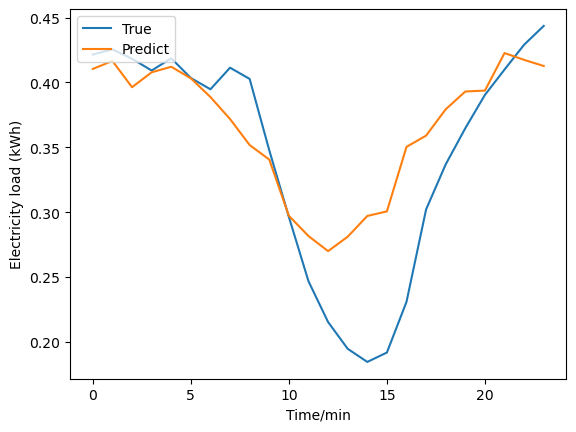

In [25]:
fig = plt.figure()
# print(test_set_squeeze[:3,param_dset_lookback:])
# print(Re[:3,param_dset_lookback:])
plt.plot(test_set_squeeze[:1,param_dset_lookback:][0])
plt.plot(Re[:1,:][0])
plt.xlabel('Time/min')
plt.ylabel('Electricity load (kWh)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()


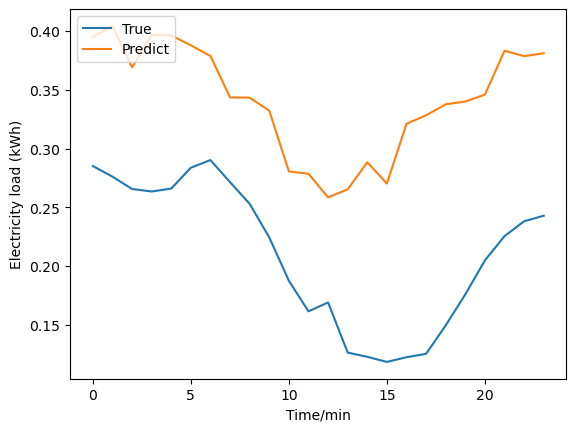

In [28]:
fig = plt.figure()
# print(test_set_squeeze[:3,param_dset_lookback:])
# print(Re[:3,param_dset_lookback:])
plt.plot(test_set_squeeze[200:201,param_dset_lookback:][0])
plt.plot(Re[200:201,:][0])
plt.xlabel('Time/min')
plt.ylabel('Electricity load (kWh)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()